## TestTemplate Notebook

This notebook should be used to submit your model for testing on the test set and the submission of you model to the general leaderboard. Please copy it to your own submission folder and fill it in. Please note that it is important that you pip install any dependencies that your model needs so that we can easily run the model. In some cases, you might want to upload an already trained model to be evaluated, instead of training your model from scracth. This is HIGHLY recommended if you use models that take a long time to train, but for small sklearn models it is not very necessary.

## Submission instructions

If you want to submit your model to be tested on the secret test sets, please implement your model in this 'SubmitRun' notebook, and make sure it works on the sample data. It is easiest to just download the 'Competition' folder for this and check that everything works. If so, please put your notebook and any other files you need (like trained model files). 

In [1]:
# Please install any packages you need in this cell
# For example: !pip install sklearn

!pip install sklearn

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display, Markdown

# Metric import
import metricutils

# import any packages your code might need here
# Put any imports here
from PIL import Image, ImageOps
import pickle
import itertools
from tqdm import tqdm
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

You will not have access to the test folder with the test data from both corpora, but you can test that your model will run properly with some samples that we have provided for you in the 'sample_data' directory.

## Adjusting paths

Depending on where you put hour notebook relative to the data, you might have slighly different paths to the training and sample data. To ensure the code works, please adjust the path in the cell below to point to the 'Competition' folder. In this case of this notebook, the path is just one folder up, so '../'. You can use either absolute or relative paths.

In [3]:
path_to_competition_folder = '../'

In [4]:
# This function can be used to load the pdf file names, gold standard json and the text dataframe

def get_data(data_path, train=True):
    """
    This function takes as input the path to either train_data or test_data, and combines
    the information present in the corpus1 and corpus2 subfolders to allow
    you to train on the all the data. the output is a dict containing the dataframe with the text,
    and a 'png' column to the path of the png files belonging to each file. It also contains the gold standard in
    binary vector format.
    
    """
    if train:
        gold_standard_path = '%s/Doclengths_of_the_individual_docs_TRAIN.json' % data_path
    else:
        gold_standard_path = '%s/Doclengths_of_the_individual_docs_TEST.json' % data_path       
    
    dataframe = pd.read_csv('%s/ocred_text.csv.gz' % data_path)
    with open(gold_standard_path, 'r') as json_file:
        gold_json = json.load(json_file)
    
    # Add the png column
    png_column = dataframe['name'] + '-' + dataframe['page'].astype(str) + '.png'
    
    # Make sure it points to the correct path
    png_column_joined = os.path.join(data_path, 'png') + os.sep + png_column
    dataframe['png'] = png_column_joined
    
    binary_gold = {key: metricutils.length_list_to_bin(val) for key, val in gold_json.items()}

    return {'csv': dataframe.sort_values(by=['name', 'page']), 'json': binary_gold}


def get_train_data(data_path):
    """
    This function takes as input the path to 'train_data' and combined
    the information present in the corpus1 and corpus2 subfolders to allow
    you to train on the all the data.
    """
  # We train on both corpus 1 and corpus 2
    c1_path = os.path.join(data_path, 'corpus1')
    c2_path = os.path.join(data_path, 'corpus2')
        
        
    c1_data = get_data(c1_path, train=True)
    c2_data = get_data(c2_path, train=True)

    combined_dataframe = pd.concat([c1_data['csv'], c2_data['csv']])
    combined_json = {**c1_data['json'], **c2_data['json']}
    combined_pdfs = c1_data['pdf'] + c2_data['pdf']
    
    return {'csv': combined_dataframe.sort_values(by=['name', 'page']), 'json': combined_json}


def get_sample_data(data_path):
    """
    This function takes as input the path to the 'sample_data' folder,
    and outputs a dictionary with the text dataframe, the gold standard json and
    the paths to the pds.
    """
    dataframe = pd.read_csv('%s/sample.csv' % data_path)
    with open('%s/sample.json' % data_path, 'r') as json_file:
        gold_json = json.load(json_file)

    # Add the png column
    png_column = dataframe['name'] + '-' + dataframe['page'].astype(str) + '.png'
    
    # Make sure it points to the correct path
    png_column_joined = os.path.join(data_path, 'png') + os.sep + png_column
    dataframe['png'] = png_column_joined
        
    binary_gold = {key: metricutils.length_list_to_bin(val) for key, val in gold_json.items()}

    return {'csv': dataframe.sort_values(by=['name', 'page']), 'json': binary_gold}

## Setting up the model

Unless you are loading in a trained model, this is where you want to insert the code to train your model.

The data is provided as a dictionary with three entries: `{'csv': _, 'json'}`.csv contains the loaded in csv file, json contains the gold standard json in binary format.

We are going to follow an approach that is similar to that of SKLearn, where you make a model that has `train` and `predict` functions. The function to score a modle will be provided by us.

Please also read the `Evaluation` notebook on the surdrive carefully, it shows how the metrics are calculated and what your format should be. Your model should return a dictionary where each key is the document ID and the value is the stream in binary vector format.

In [5]:
class Model:
    def __init__(self):
        self.cluster_algorithm = AgglomerativeClustering(linkage='average',
                                                         n_clusters=None,
                                                         affinity='cosine',
                                                         distance_threshold=0.5)

    def train(self, train_data):

    # I will not use the pdfs or the json so I will just
    # extract the text data

        predictions = {}

        # Now we use clustering, we don't set N and let the algorithm decide

        for stream_id, stream_df in tqdm(train_data['csv'].groupby('name')):
            # Sort the dataframe
            stream_df = stream_df.sort_values(by='page')

              # Extract the text
            text = stream_df['text'].fillna('').tolist()

            if len(text) == 1:
                predictions[stream_id] = [1]
                continue
            # Convert the text to Count vectors
            vectorizer_algorithm = CountVectorizer(analyzer='char_wb',
                                                     ngram_range=(2, 3))

            # Now we create the page vectors from the vectorizer
            page_vectors = vectorizer_algorithm.fit_transform(text)

            # account for empty pages
            self.cluster_algorithm.fit(np.asarray(page_vectors.todense())+0.000001)
            output_labels = self.cluster_algorithm.labels_
            consec_blocks = [len(list(group)) for bit, group in itertools.groupby(output_labels)]
            # return binary vectors
            predictions[stream_id] = metricutils.length_list_to_bin(consec_blocks)

        return predictions

    def predict(self, input_dict):
        # in this case of our model we can just return the output of train
        # as our model doesnt really 'train'
        return self.train(input_dict)
        

## Training the model (optional)

If your model requires trainin you can put this boolean to true. If not, you can leave it as-is.

In [6]:
MyModel = Model()

from_scratch = False
if from_scratch:
    train_data = get_train_data(os.path.join(path_to_competition_folder, 'train_data'))
    MyModel.train(train_data)

## Checking the model

For this we will make a prediction with the model on the sample data, and see how whether it works and gives us some scores. Please also add a descriptive name of your model below (preferably also containing your name), this will be used as a title of the plots shown on the test sets, and helps us keep it clear which plots came from which models.

In [7]:
short_model_description = "Constrained agglomerative Clustering model with character ngrams and cosine similarity by Ruben"

In [8]:
run_on_test = False

if run_on_test:
    
    corpus1_test_data = get_data(os.path.join(path_to_competition_folder, 'test_data/corpus1'), train=False)
    corpus2_test_data = get_data(os.path.join(path_to_competition_folder, 'test_data/corpus2'), train=False)
    
    predictions_corpus1 = predictions = MyModel.predict(corpus1_test_data)
    predictions_corpus2 = predictions = MyModel.predict(corpus2_test_data)

else:
    
    data = get_sample_data(os.path.join(path_to_competition_folder, 'sample_data'))
    
    # You should not have to adjust anything here, the model should just return predections in binary format
    predictions = MyModel.predict(data)



100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


<b>Scores for the model on the sample data</b>

<b> Mean scores of the evaluation metrics for Constrained agglomerative Clustering model with character ngrams and cosine similarity by Ruben </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,0.10,0.78,0.15,19.0,0.04-0.16,0.7-0.86,0.08-0.22
Bcubed,0.93,0.18,0.22,19.0,0.88-0.98,0.1-0.26,0.14-0.3
WindowDiff,0.06,0.06,0.06,19.0,0.01-0.11,0.01-0.11,0.01-0.11
Block,0.02,0.08,0.04,19.0,-0.01-0.05,0.03-0.13,0.0-0.08
Weighted Block,0.05,0.18,0.08,19.0,0.01-0.09,0.1-0.26,0.03-0.13


<b> KDE Plots of the scores of the evaluation metrics for Constrained agglomerative Clustering model with character ngrams and cosine similarity by Ruben </b>

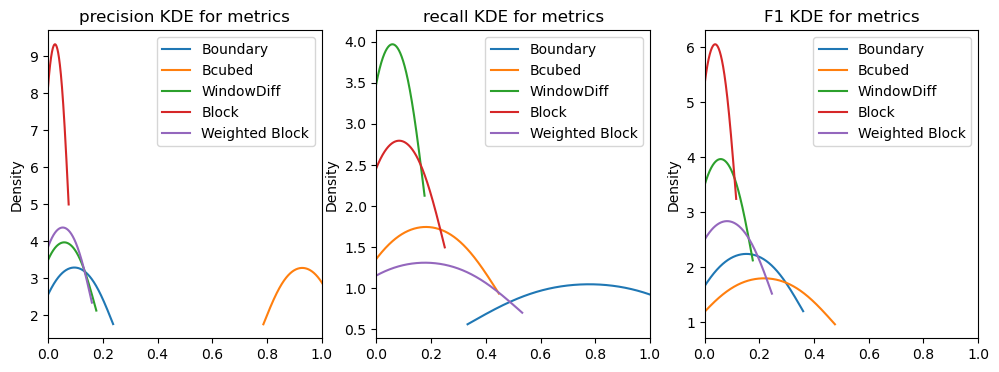

In [9]:
if run_on_test:
    display(Markdown("<b>Scores for the model on corpus 1</b>"))
    metricutils.evaluation_report(corpus1_test_data['json'], predictions_corpus1, title=short_model_description)
    
    display(Markdown("<b>Scores for the model on corpus 2</b>"))
    metricutils.evaluation_report(corpus2_test_data['json'], predictions_corpus2, title=short_model_description)
else:
    display(Markdown("<b>Scores for the model on the sample data</b>"))
    metricutils.evaluation_report(data['json'], predictions, title=short_model_description)

## Using the PNG files

Below is a very simple model that uses only the PNG files, as an example of how to load these in and work with the visual information.

In [10]:
class Model:
    """
    This is a super simple model that just reads in each PNG image of a stream in grayscale
    and uses cosine similarity between the resulting vectors. A boundary is classified if the
    similarity is below a threshold. Because we dont really train we will just implement the predict function.
    Because it is just an example, we will just use the first 1000 pixels for the predictions.
    """
    def __init__(self):
        pass


    def predict(self, input_dict, threshold=0.000005):
        """
        This predict function loops over all the streams in the csv
        loads in the png files, converts the images to grayscale and 
        cosine similarity between the first 1000 pixels.
        """
        predictions = {}
        
        df = input_dict['csv']
        
        for stream_id, stream_df in df.groupby('name'):
            grayscale_vectors = []
            
            png_paths = stream_df['png']
            for png_path in png_paths:
            # now load them in an save the vectors
                image = Image.open(png_path)   
                gray_image = ImageOps.grayscale(image)
                grayscale_vectors.append(np.array(gray_image).reshape(-1, 1)[:1000])
            
            grayscale_matrix = np.hstack(grayscale_vectors)
            # get the cosine similarity matrix by normalizing the vecotrs
            n = np.linalg.norm(grayscale_matrix, axis=0).reshape(1, grayscale_matrix.shape[1])
            cosine_mat = grayscale_matrix.T.dot(grayscale_matrix) / n.T.dot(n)
            
            # now we extract the diagonal +1 as this gives us similarity between consecutive pages
            sim_with_next = np.diag(cosine_mat, 1)

            # now all we have to do is set everything lower than the threshold to 1 (new page) and 0 otherwise
            prediction = np.where(sim_with_next < threshold, 1, 0) # one if true, zero otherwise
            prediction[0] = 1
            
            # we miss the similarity of the last page with the next, just put this to zero
            prediction = np.append(prediction, 0)
            
            predictions[stream_id] = prediction
        
        return predictions

In [11]:
MyModel = Model()
run_on_test = False

if run_on_test:
    
    corpus1_test_data = get_data(os.path.join(path_to_competition_folder, 'test_data/corpus1'), train=False)
    corpus2_test_data = get_data(os.path.join(path_to_competition_folder, 'test_data/corpus2'), train=False)
    
    predictions_corpus1 = predictions = MyModel.predict(corpus1_test_data)
    predictions_corpus2 = predictions = MyModel.predict(corpus2_test_data)

else:
    
    data = get_sample_data(os.path.join(path_to_competition_folder, 'sample_data'))
    
    # You should not have to adjust anything here, the model should just return predections in binary format
    predictions = MyModel.predict(data)



<b>Scores for the model on the sample data</b>

<b> Mean scores of the evaluation metrics for Constrained agglomerative Clustering model with character ngrams and cosine similarity by Ruben </b>

,precision,recall,F1,support,CI Precision,CI Recall,CI F1
Boundary,0.05,0.97,0.10,19.0,0.02-0.08,0.95-0.99,0.06-0.14
Bcubed,0.98,0.14,0.16,19.0,0.96-1.0,0.1-0.18,0.11-0.21
WindowDiff,0.06,0.06,0.06,19.0,0.03-0.09,0.03-0.09,0.03-0.09
Block,0.02,0.17,0.03,19.0,0.0-0.04,0.12-0.22,0.01-0.05
Weighted Block,0.02,0.19,0.03,19.0,0.0-0.04,0.14-0.24,0.01-0.05


<b> KDE Plots of the scores of the evaluation metrics for Constrained agglomerative Clustering model with character ngrams and cosine similarity by Ruben </b>

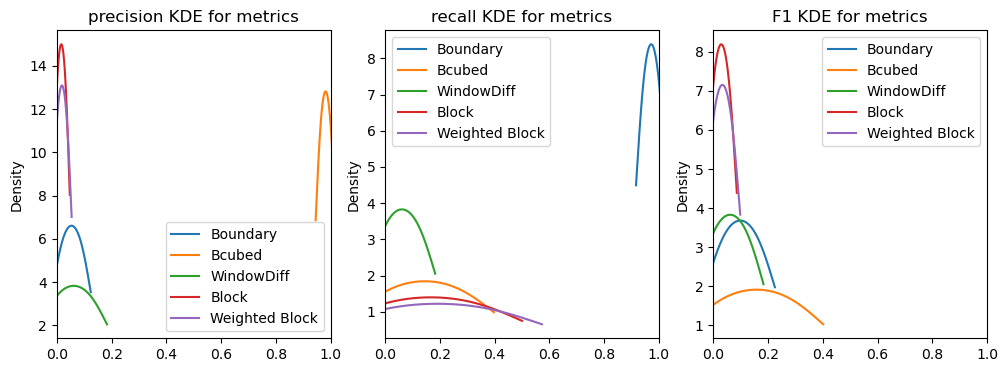

In [12]:
if run_on_test:
    display(Markdown("<b>Scores for the model on corpus 1</b>"))
    metricutils.evaluation_report(corpus1_test_data['json'], predictions_corpus1, title=short_model_description)
    
    display(Markdown("<b>Scores for the model on corpus 2</b>"))
    metricutils.evaluation_report(corpus2_test_data['json'], predictions_corpus2, title=short_model_description)
else:
    display(Markdown("<b>Scores for the model on the sample data</b>"))
    metricutils.evaluation_report(data['json'], predictions, title=short_model_description)